In [1]:
import sys
sys.path.append('../')
from src.OmicsGenerator import OmicsGenerator
from src.visualization import plot_timecourse, plot_pca
from src.inference import infer_glv_params

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
from matplotlib import cm

import numpy as np
np.random.seed(10 )

# Initialize generator with intervention

In [2]:
# initialize generator:
gen = OmicsGenerator(
    100,                   # 100 time points
    ['mgx', 'mbx'],        # 2 nodes named 'mgx' and 'mbx'
    [15, 15],              # each node has 15 dimensions
    init_full=True         # set interaction matrices and growth rates randomly
)

# add intervention:
gen.add_intervention(
    'int1',                # intervention name
    'mgx',                 # apply to 'mgx' node
    10*np.random.rand(15), # set intervention response vector randomly
    start=50,              # start at t=50
    end=100                # go to end
)

Node 'mgx' initialized
Node 'mbx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:15    0:15
Interaction 'mgx->mbx' added
set m:(mgx)->(mbx):   0:15    15:30
Interaction 'mbx->mgx' added
set m:(mbx)->(mgx):   15:30    0:15
Interaction 'mbx->mbx' added
set m:(mbx)->(mbx):   15:30    15:30
Added growth rates to node mgx
Added growth rates to node mgx
Added growth rates to node mbx
Added growth rates to node mbx
Initialized


# Single timecourse

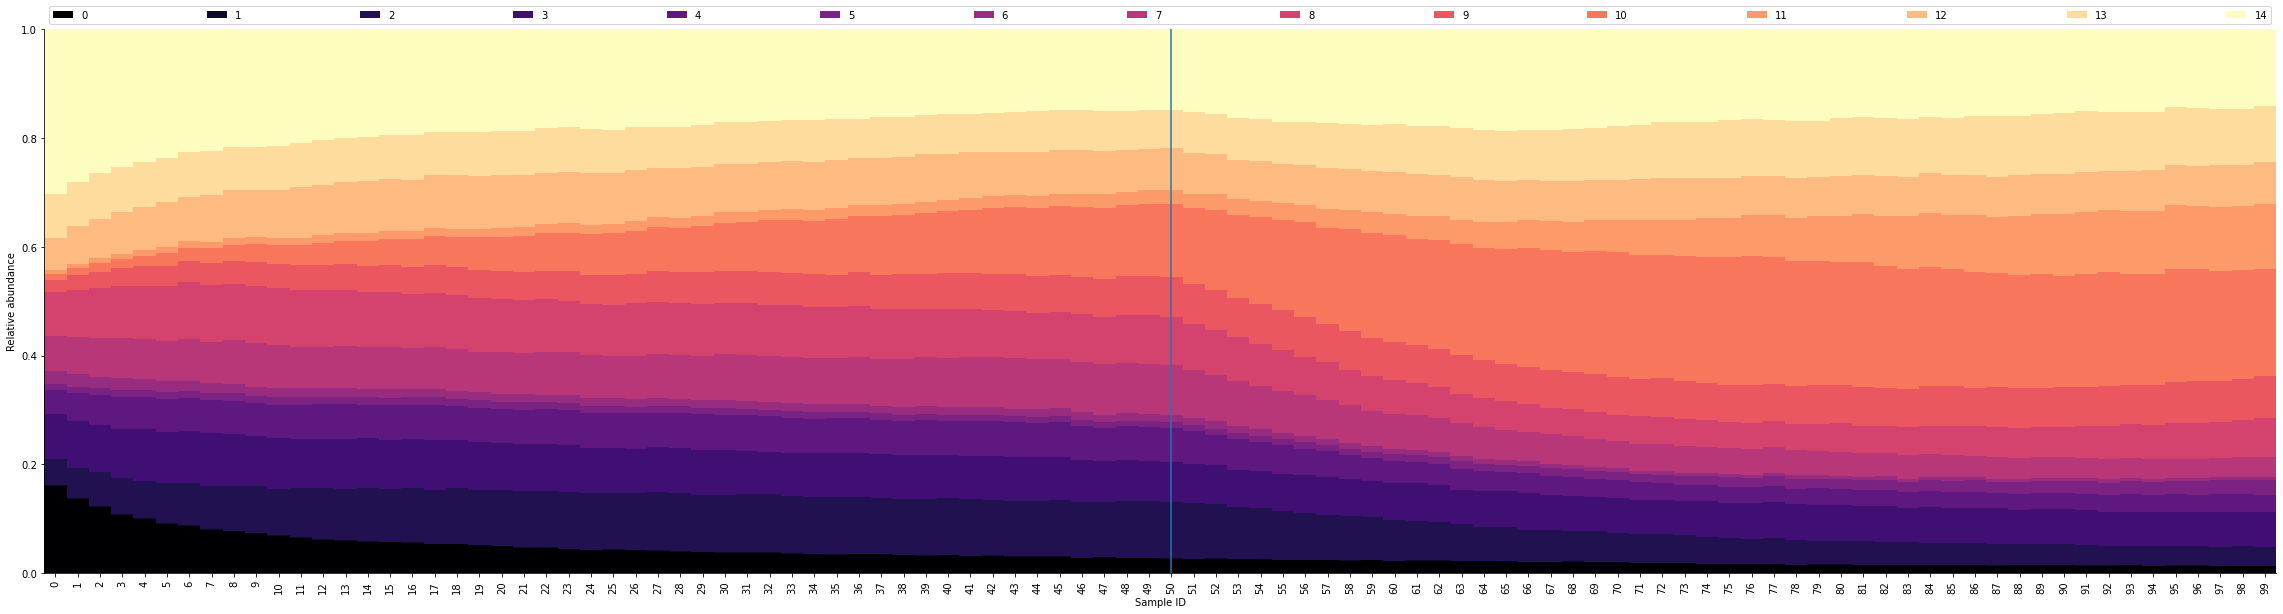

In [3]:
# run generator and plot:
x1, y1, z1 = gen.generate(dt=1e-2)
plot_timecourse(y1['mgx'])
plt.vlines(50, 0, 1)


# Multiple timecourses

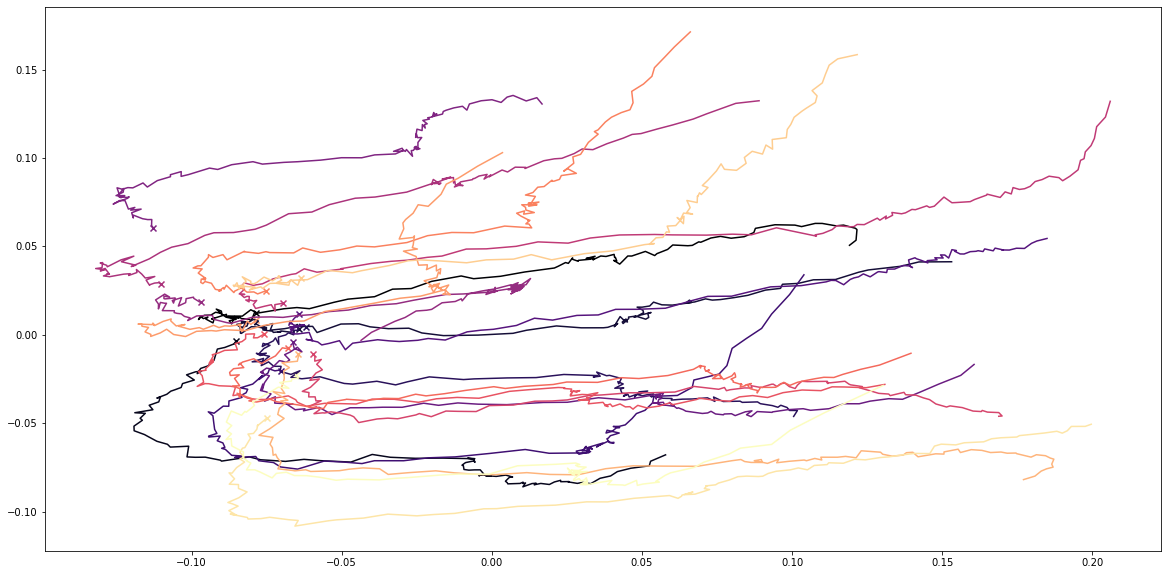

In [4]:
# run multi-generator and plot:
x2, y2, z2 = gen.generate_multiple(20)
plot_pca([y2], 'mgx')


# Case-control

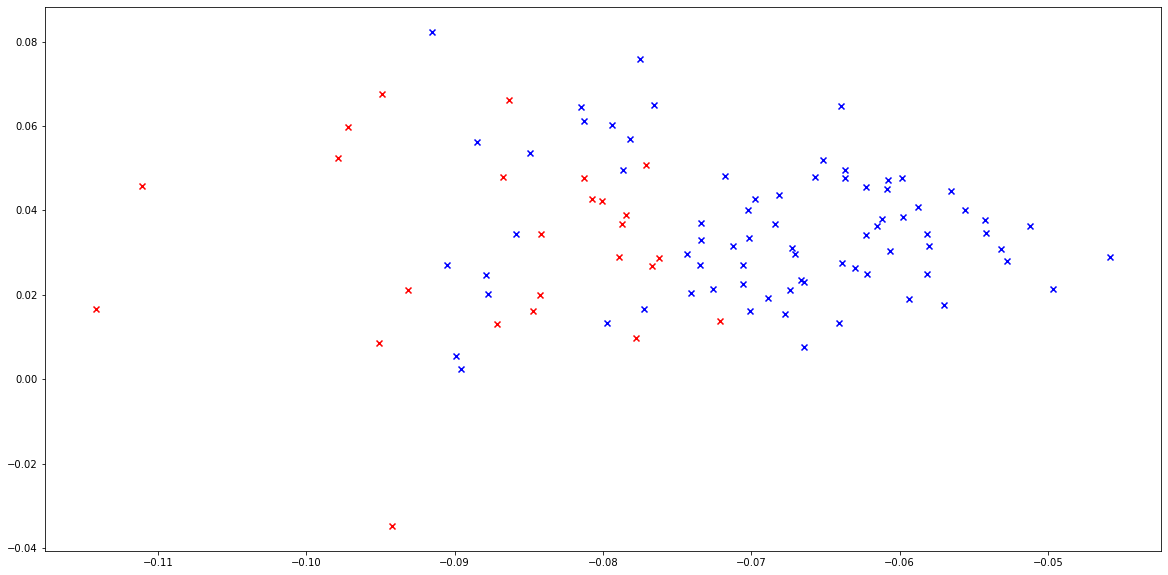

In [5]:
# run case-control and plot:
x3_control, y3_control, z3_control, x3_case, y3_case, z3_case = gen.case_control(100, .75, 'mgx', 1)
plot_pca([y3_control, y3_case], 'mgx', colors=['red', 'blue'], plot_trajectories=False)


# Using learned interaction matrices

Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:15    0:15
Added growth rates to node mgx
Added growth rates to node mgx
Initialized
Node 'mgx' initialized
Initialized
Interaction 'M' added
Added growth rates to node mgx
Added growth rates to node mgx


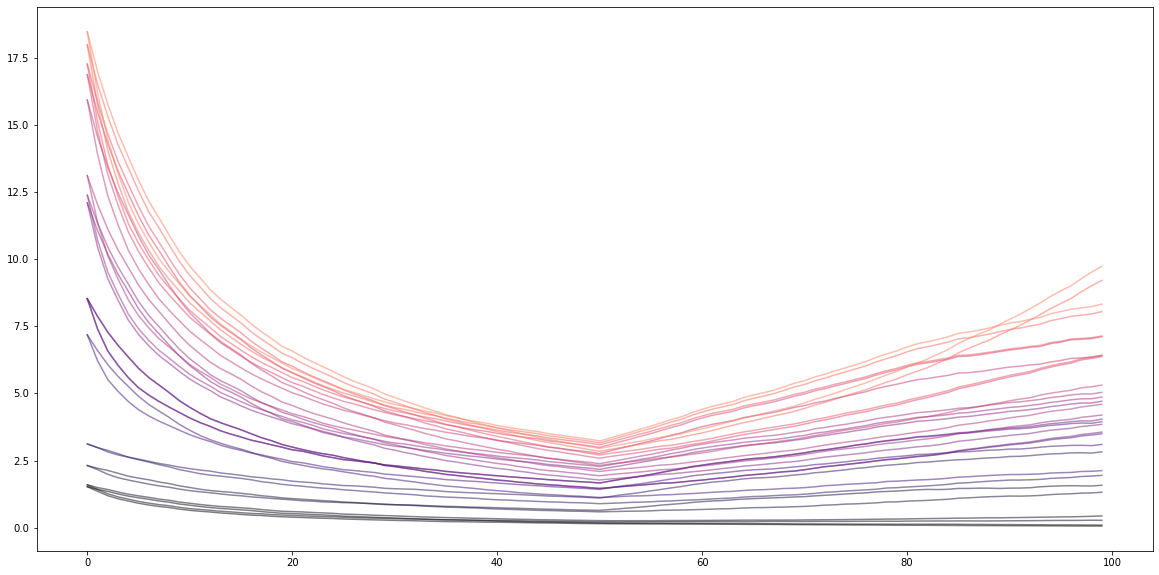

In [6]:
# run case-control and plot:
gen4 = OmicsGenerator(
    100,                   # 100 time points
    ['mgx'],               # 1 nodes named 'mgx'
    [15],                  # 'mgx' has 8 dimensions
    init_full=True         # set interaction matrices and growth rates randomly
)

# add intervention:
gen4.add_intervention(
    'int1',                # intervention name
    'mgx',                 # apply to 'mgx' node
    10*np.random.rand(15), # set intervention response vector randomly
    start=50,              # start at t=50
    end=100                # go to end
)

# generate training data
x4, y4, z4 = gen4.generate(dt=1e-2)

# infer params
M, u, E = infer_glv_params(
    z4['mgx'],             # use (latent) absolute abundances
    gen4.get('int1').U,    # assume intervention indicator is known
    interaction_reg=100,   # L1 penalty for interaction matrix
    growth_reg=0,          # L1 penalty for growth rates
    intervention_reg=0,    # L1 penalty for intervention responses
    dt=1e-2                # same time-step as generator
)

# build inferred generator
gen4_inferred = OmicsGenerator(100, ['mgx'], [15])
gen4_inferred.add_interaction('M', 'mgx', 'mgx', M)
gen4_inferred.add_intervention('int1', 'mgx', E.reshape(-1), start=50, end=100)
gen4_inferred.set_initial_value('mgx', u.reshape(-1), growth_rate=True)
gen4_inferred.set_initial_value('mgx', gen4.get('mgx').initial_value) # same init. abundances as gen 1

x4_inferred, y4_inferred, z4_inferred = gen4_inferred.generate(dt=1e-2)

# plot both trajectories
colors = cm.get_cmap('magma', 20)(range(15))

for i in range(15):
    plt.plot(np.cumsum(z4_inferred['mgx'], axis=1)[:,i], alpha=0.5, c=colors[i])
    plt.plot(np.cumsum(z4['mgx'], axis=1)[:,i], alpha=0.5, c=colors[i])